In [1]:
using SBMLToolkit, ModelingToolkit, DifferentialEquations, StochasticDiffEq
using Plots
using DataFrames
using CSV
using Random
using Distributions
using SBML
using SymbolicUtils
using StaticArrays
using Catalyst
using AdvancedMH
using MCMCChains
using MCMCChainsStorage
using AbstractMCMC
import StatsPlots
using ArviZ
using HDF5

using Particles
using ParticlesDE
using StaticDistributions

include("utilities.jl")
include("sir_model.jl");

## SIR-model likelihoods
In this notebook I investigate the likelihood landscape and identifiability of parameters.

In [4]:
# set number of particles
nparticles = 100
true_par = problem.p

llh_no_priors = LogLikelihood_NoGradient(ssm, real_data; nparticles=nparticles)
no_priors_model = DensityModel(llh_no_priors)

In [3]:
# on log10 scale for the sinlge loops
beta_val = -3:0.01:0; 
gamma_val = -3:0.01:0;

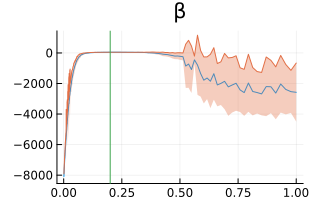

In [5]:
beta_likelihoods = CSV.read("./output/sir_model_beta_likelihoods_200p_no_priors.csv", DataFrame);

plt = Plots.plot(size=(width_px/2,width_px/3), leg=false, title="β")
Plots.plot!(plt, [10^(b) for b in beta_val], (beta_likelihoods[:, "Likelihood"]))
Plots.plot!(plt, [10^(b) for b in beta_val], 
    (beta_likelihoods[:, "Likelihood"]+1.96*beta_likelihoods[:, "Std_Error"]),
    fillrange=beta_likelihoods[:, "Likelihood"]-1.96*beta_likelihoods[:, "Std_Error"],
    fillalpha=0.35)
Plots.plot(plt, [0.2], seriestype="vline", label="true value")

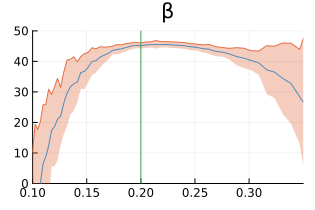

In [22]:
plt = Plots.plot(size=(width_px/2,width_px/3), leg=false, title="β")
Plots.plot!(plt, [10^(b) for b in beta_val], beta_likelihoods[:, "Likelihood"])
Plots.plot!(plt, [10^(b) for b in beta_val], 
    (beta_likelihoods[:, "Likelihood"]+1.96*beta_likelihoods[:, "Std_Error"]),
    fillrange=beta_likelihoods[:, "Likelihood"]-1.96*beta_likelihoods[:, "Std_Error"],
    fillalpha=0.35)
Plots.plot!(plt, [0.2], seriestype="vline", label="true value")
Plots.plot!(plt, xlims=(0.1,0.35), ylims=(0,50))

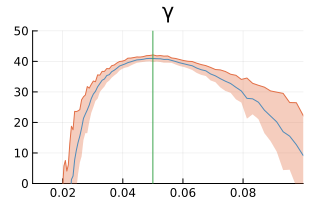

In [20]:
gamma_likelihoods = CSV.read("./output/sir_model_gamma_likelihoods_200p_no_priors.csv", DataFrame);

plt = Plots.plot(size=(width_px/2,width_px/3), leg=false, title="γ")
Plots.plot!(plt, [10^(b) for b in gamma_val], gamma_likelihoods[:, "Likelihood"], label="mean likelihood")
Plots.plot!(plt, [10^(b) for b in gamma_val], 
            gamma_likelihoods[:, "Likelihood"]+1.96*gamma_likelihoods[:, "Std_Error"],
            fillrange=gamma_likelihoods[:, "Likelihood"]-1.96*gamma_likelihoods[:, "Std_Error"],
            fillalpha=0.35, label="95% CI")
Plots.plot!(plt, [0.05], seriestype="vline", label="true value")
Plots.plot!(plt, xlims=(0.01,0.1), ylims=(0,50))

### Choose maxima
Next, we choose out of the colelctions with priors the maxima and see how they perform in the data check.

In [11]:
# get maxima
true_parameter=problem.p 
beta_max = beta_likelihoods[findmax(beta_likelihoods[!, "Likelihood"])[2],:]
beta_max = 10^beta_max["Parameter"]
gamma_max = beta_likelihoods[findmax(gamma_likelihoods[!, "Likelihood"])[2],:];
gamma_max = 10^gamma_max["Parameter"];

In [12]:
plt1, plt2 = data_check_plot(problem, true_parameter, tobs, y_load)
display(plt1)
display(plt2)

Relative mean squared error in... Prev: 0.009790883494692456      Infc: 0.001844877910820053

In [13]:
new_parameter = copy(true_parameter)
new_parameter[1]=beta_max

plt1, plt2 = data_check_plot(problem, new_parameter, tobs, y_load)
display(plt1)
display(plt2)

Relative mean squared error in... Prev: 0.017391097910232793      Infc: 0.004855226476912254

In [14]:
new_parameter = copy(true_parameter)
new_parameter[2] = gamma_max

plt1, plt2 = data_check_plot(problem, new_parameter, tobs, y_load)
display(plt1)
display(plt2)

Relative mean squared error in... Prev: 0.009914818781165572      Infc: 0.001957780950422845

So we see that the parameter obtained from the maximum of $\gamma$ for the true beta can decrease the mean squared error of the first observable slightly but increases it on the second. The paramter obtained by maximising $\beta$ conditioned on $\gamma$, the mean squared error increases compared to the true paramter performance.

In [15]:
new_parameter = copy(true_parameter)
new_parameter[1] = beta_max
new_parameter[2] = gamma_max

plt1, plt2 = data_check_plot(problem, new_parameter, tobs, y_load)
display(plt1)
display(plt2)

Relative mean squared error in... Prev: 0.018615260593995504      Infc: 0.005740632180290364

Combining the two maxima increases the error, as expected, sicne the maxima were obtained conditioned on the other paramter fixed

All the above shows that the likelihood landscape admits a clear high probability area and parameters should be identifiable.